 # create Dataset with 3s long samples

In [2]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras

# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
from librosa.display import waveshow
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint
import random
import time

# Check if the GPU is available
print("GPU", "available, YES" if tf.config.list_physical_devices("GPU") else "no GPU")



Tensorflow Version: 2.13.0
GPU available, YES


In [3]:
# set sr
config = {
    'sr': 44100,
    'cleanraw': '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/DAPS/cleanraw/*.wav',
    'tfrecords_path': '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/'
}

# print config
print(json.dumps(config, indent=4))

# # save config to disk
# with open('./3_DC_config.json', 'w+') as fp:
#     json.dump(config, fp, sort_keys=True, indent=4)


{
    "sr": 44100,
    "cleanraw": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/DAPS/cleanraw/*.wav",
    "tfrecords_path": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/"
}


# func to save dataset to tfrecords of ~100mb

In [36]:
def load_and_process_data(file_path):

    # load audio data 
    cleanraw, _ = librosa.load(file_path, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_fast')
    
    
    # # paths for ground truths prod files
    fps_prod = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech/*.wav')
    
    # get string with speaker and scriptname
    label = file_path.split('/')[-1]
    label = label[:11]
    for filename in fps_prod:
        if label in filename:
            fp = filename
            break

    # load corresponding produced audio file
    produced, _ = librosa.load(fp, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_fast')

    # cut audio into 3s frames
    seg = 3*int(config['sr'])
    cleanraw_3s = librosa.util.frame(cleanraw, frame_length=seg, hop_length=seg).T
    produced_3s = librosa.util.frame(produced, frame_length=seg, hop_length=seg).T    

    # # get shape
    # print('y_3s.shape:', cleanraw_3s.shape)
    # print('produced_3s.shape:', produced_3s.shape)

    return cleanraw_3s, produced_3s


def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


# tfrecords writer
def save_tfrecords(tfrecords_path: str,
                   pred_list: list,
                   produced_list: list,
                   config: dict):

    # tfrecords writer
    with tf.io.TFRecordWriter(tfrecords_path) as writer:
        for v_array, p_array in zip(pred_list, produced_list):

            # encode
            v_encoded = tf.audio.encode_wav(v_array[:, np.newaxis], config['sr'])
            p_encoded = tf.audio.encode_wav(p_array[:, np.newaxis], config['sr'])
        
            # save feature
            feature = {'voicefixer': _bytes_feature(v_encoded),
                       'produced': _bytes_feature(p_encoded)}
            features = tf.train.Features(feature=feature)
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())


        # close writer
        writer.close()

# Save Train Dataset

In [37]:
# folder with the training data
train_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/train/*.wav')
print('train_files length:', len(train_files))

cleanraw_list = []
produced_list = []

# for 3s files
length_tf_records = 180 # ~100mb
sr = config['sr']


i=0
for idx, file in enumerate(train_files):
    cleanraw, produced = load_and_process_data(file)
    cleanraw_list.extend(cleanraw)
    produced_list.extend(produced)
    print(len(cleanraw_list), len(produced_list))

    if len(cleanraw_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/train_tfrecords/train_{i}_{sr}_Hz_cleanraw.tfrecords', cleanraw_list[:length_tf_records], produced_list[:length_tf_records], config)
        cleanraw_list = cleanraw_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')

# save last tfrecord
save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/train_tfrecords/train_{i}_{sr}_Hz_cleanraw.tfrecords', cleanraw_list, produced_list, config)



train_files length: 80
51 51
113 113
168 168
214 214
tfrecord #1 saved
89 89
137 137
201 201
tfrecord #2 saved
77 77
117 117
166 166
210 210
tfrecord #3 saved
81 81
136 136
181 181
tfrecord #4 saved
52 52
109 109
166 166
218 218
tfrecord #5 saved
97 97
148 148
214 214
tfrecord #6 saved
90 90
151 151
202 202
tfrecord #7 saved
70 70
126 126
174 174
231 231
tfrecord #8 saved
105 105
163 163
222 222
tfrecord #9 saved
92 92
136 136
190 190
tfrecord #10 saved
63 63
107 107
156 156
215 215
tfrecord #11 saved
80 80
138 138
183 183
tfrecord #12 saved
58 58
117 117
164 164
223 223
tfrecord #13 saved
90 90
145 145
191 191
tfrecord #14 saved
64 64
117 117
173 173
232 232
tfrecord #15 saved
105 105
171 171
225 225
tfrecord #16 saved
107 107
166 166
218 218
tfrecord #17 saved
91 91
150 150
200 200
tfrecord #18 saved
72 72
127 127
186 186
tfrecord #19 saved
54 54
103 103
143 143
184 184
tfrecord #20 saved
57 57
102 102
161 161
216 216
tfrecord #21 saved
91 91
137 137
200 200
tfrecord #22 saved
72 72


# Save test Dataset

In [38]:
# folder with the training data
train_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/test/*.wav')
print('files length:', len(train_files))

cleanraw_list = []
produced_list = []

# for 3s files
length_tf_records = 180 # ~100mb
sr = config['sr']


i=0
for idx, file in enumerate(train_files):
    cleanraw, produced = load_and_process_data(file)
    cleanraw_list.extend(cleanraw)
    produced_list.extend(produced)
    print(len(cleanraw_list), len(produced_list))

    if len(cleanraw_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/test_tfrecords/test_{i}_{sr}_Hz_cleanraw.tfrecords', cleanraw_list[:length_tf_records], produced_list[:length_tf_records], config)
        cleanraw_list = cleanraw_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')

# save last tfrecord
save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/test_tfrecords/test_{i}_{sr}_Hz_cleanraw.tfrecords', cleanraw_list, produced_list, config)


files length: 10
52 52
95 95
144 144
190 190
tfrecord #1 saved
48 48
93 93
138 138
190 190
tfrecord #2 saved
65 65
112 112


# Save valid Dataset

In [39]:
# folder with the training data
train_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/valid/*.wav')
print('files length:', len(train_files))

cleanraw_list = []
produced_list = []

# for 3s files
length_tf_records = 180 # ~100mb
sr = config['sr']


i=0
for idx, file in enumerate(train_files):
    cleanraw, produced = load_and_process_data(file)
    cleanraw_list.extend(cleanraw)
    produced_list.extend(produced)
    print(len(cleanraw_list), len(produced_list))

    if len(cleanraw_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/valid_tfrecords/valid_{i}_{sr}_Hz_cleanraw.tfrecords', cleanraw_list[:length_tf_records], produced_list[:length_tf_records], config)
        cleanraw_list = cleanraw_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')

# save last tfrecord
save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/valid_tfrecords/valid_{i}_{sr}_Hz_cleanraw.tfrecords', cleanraw_list, produced_list, config)
    


files length: 10
57 57
121 121
185 185
tfrecord #1 saved
79 79
145 145
203 203
tfrecord #2 saved
70 70
128 128
188 188
tfrecord #3 saved
61 61


# Check the Data by plot and audio display

In [40]:
# audio conversion
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)

(22050, 1) (22050, 1)
float32 float32


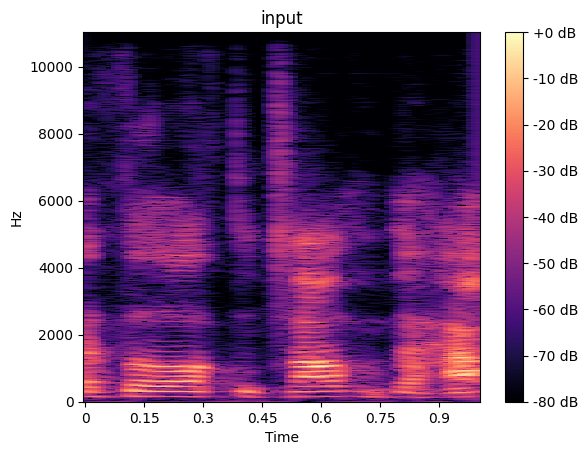

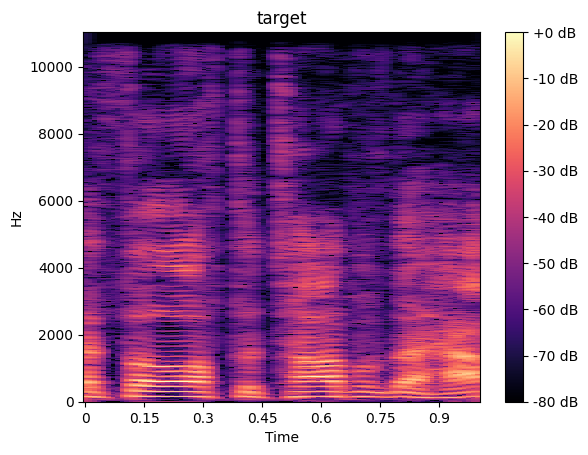

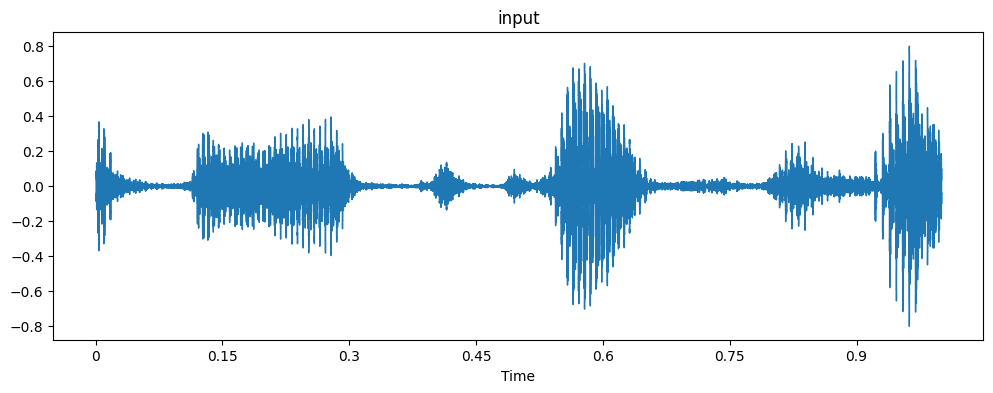

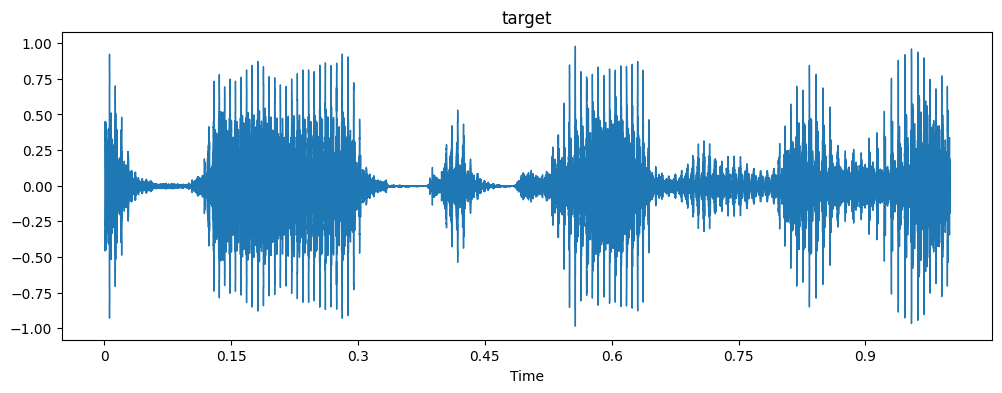

In [6]:
import os
from scipy.io.wavfile import write
import helpers
from helpers import *
import librosa
from IPython.display import Audio


AUTOTUNE = tf.data.experimental.AUTOTUNE

# # load tf records
# path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/'
# dataset = tf.data.TFRecordDataset(os.path.join(path, 'train_201_44100_Hz.tfrecords'))

# load tf record
path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/train_46_44100_Hz.tfrecords'
#path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/valid_tfrecords/valid__13_44100_Hz.tfrecords'
#path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/train_tfrecords/train_9_44100_Hz_cleanraw.tfrecords'
dataset = tf.data.TFRecordDataset(path)
dataset = dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)

# augment dataset
# dataset = dataset.map(volume_change, num_parallel_calls=AUTOTUNE)
# dataset = dataset.map(bandpass_wrapper, num_parallel_calls=AUTOTUNE)
# dataset = dataset.map(samples_to_zero, num_parallel_calls=AUTOTUNE)
# dataset = dataset.map(roll, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(shift_samples_x, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(resample_wrapper, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(take_1s_22050, num_parallel_calls=AUTOTUNE)



dataset = dataset.as_numpy_iterator()
for i, sample in enumerate(dataset):

    wav_VF = sample[0]
    wav_P = sample[1]

    sr = 22050

    

    # get shape
    print(wav_VF.shape, wav_P.shape)
    # get dtype
    print(wav_VF.dtype, wav_P.dtype)
  
    # calculate stft
    V = np.abs(librosa.stft(np.transpose(wav_VF), n_fft=2048, hop_length=256, win_length=2048))
    P = np.abs(librosa.stft(np.transpose(wav_P), n_fft=2048, hop_length=256, win_length=2048))

    # convert to db
    voicefixer = librosa.amplitude_to_db(np.abs(V), ref=np.max)
    produced = librosa.amplitude_to_db(np.abs(P), ref=np.max)

    # plot spectrograms
    librosa.display.specshow(data = np.squeeze(voicefixer), sr = sr, hop_length=256, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('input')
    plt.show()
    librosa.display.specshow(data = np.squeeze(produced), sr =sr, hop_length=256, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('target')
    plt.show()

    # plot waveforms
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(np.transpose(wav_VF), sr=sr)
    plt.title('input')
    plt.show()
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(np.transpose(wav_P), sr=sr)
    plt.title('target')
    plt.show()

    # save audio
    write('./3_input.wav', int(sr), float2pcm(wav_VF))
    write('./3_target.wav', int(sr), float2pcm(wav_P))

    break

# get some files to check sampleshift

In [9]:
import os
from scipy.io.wavfile import write
import helpers
from helpers import *
import librosa
from IPython.display import Audio


AUTOTUNE = tf.data.experimental.AUTOTUNE

# # load tf records
# path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/'
# dataset = tf.data.TFRecordDataset(os.path.join(path, 'train_201_44100_Hz.tfrecords'))

# load tf record
#path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/train_23_44100_Hz.tfrecords'
#path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/valid_tfrecords/valid__2_44100_Hz.tfrecords'
path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/test__1_44100_Hz.tfrecords'
#path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/train_tfrecords/train_9_44100_Hz_cleanraw.tfrecords'
dataset = tf.data.TFRecordDataset(path)
dataset = dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)

# augment dataset
# dataset = dataset.map(volume_change, num_parallel_calls=AUTOTUNE)
# dataset = dataset.map(bandpass_wrapper, num_parallel_calls=AUTOTUNE)
# dataset = dataset.map(samples_to_zero, num_parallel_calls=AUTOTUNE)
# dataset = dataset.map(roll, num_parallel_calls=AUTOTUNE)
#dataset = dataset.map(shift_samples_x, num_parallel_calls=AUTOTUNE)
#dataset = dataset.map(resample_wrapper, num_parallel_calls=AUTOTUNE)
#dataset = dataset.map(take_1s_22050, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(take_1s_44100, num_parallel_calls=AUTOTUNE)

shifts = [50,55,60,65,70,75,80,85,90,95,100]

#get one pair of samples
dataset = dataset.as_numpy_iterator()
for sample in dataset:
    wav1 = sample[0]
    wav2 = sample[1]
    break

print(wav1.shape, wav2.shape)
print(type(wav1), type(wav2))

for i in range(len(shifts)):
    wav1, wav2 = shift_samples_x(wav1, wav2, shifts[i])
    

    sr = 44100

    # save audio
    write(f'./_samples/{shifts[i]}_input.wav', int(sr), float2pcm(wav1))
    write(f'./_samples/{shifts[i]}_target.wav', int(sr), float2pcm(wav2))

    print(i)

# 75 ,80
    

(44100, 1) (44100, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
0
1
2
3
4
5
6
7
8
9
10


# check filters

In [2]:
import os
from scipy.io.wavfile import write
from scipy.fftpack import fft, ifft
from helpers import *
import librosa
from IPython.display import Audio
from scipy.signal import butter, lfilter, freqz, filtfilt


AUTOTUNE = tf.data.experimental.AUTOTUNE

# # load tf records
# path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/'
# dataset = tf.data.TFRecordDataset(os.path.join(path, 'train_201_44100_Hz.tfrecords'))

# load tf record
path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/_cleanraw-produced/train_tfrecords/train_9_44100_Hz_cleanraw.tfrecords'
dataset = tf.data.TFRecordDataset(path)
dataset = dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)

# augment dataset
dataset = dataset.map(volume_change, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(bandpass_wrapper, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(samples_to_zero, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(roll, num_parallel_calls=AUTOTUNE)

for d in dataset:
    print(d[0])
    break

fs=44100

dataset = dataset.as_numpy_iterator()
for i, sample in enumerate(dataset):

    input = np.transpose(sample[0])
    target = np.transpose(sample[1])

    # get shape and dtype
    print('transposed numpy array:', input.shape, target.shape)
    print(input.dtype, target.dtype)

    sr = 44100
    order = 6
    # # random range for lowcut and highcut
    lowcut = tf.random.uniform([], 150, 200)
    highcut = tf.random.uniform([], 7000, 8000)
    # lowcut = 200
    # highcut = 7300

    # getting filter coefficients and filter audio
    b, a = butter(order, [lowcut, highcut], fs=44100, btype='band')
    w, h = freqz(b, a, fs=fs)

    # plt.figure(figsize=(6, 3))
    # plt.plot(w, abs(h), label="order = %d" % order)
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Gain')
    # plt.grid(True)
    # plt.legend(loc='best')


    # input_filtered = filtfilt(b, a, input)

    # plot waveforms
    plt.figure(figsize=(6, 3))
    librosa.display.waveshow(input, sr=44100)
    plt.title('input')
    plt.show()
    plt.figure(figsize=(6, 3))
    librosa.display.waveshow(target, sr=44100)
    plt.title('target')
    plt.show()

    # save audio
    write('./3_1input.wav', int(44100), float2pcm(input.T))
    write('./3_1target.wav', int(44100), float2pcm(target.T))


    # # stft
    # V = np.abs(librosa.stft(input, n_fft=2048, hop_length=256, win_length=2048))
    # P = np.abs(librosa.stft(input_filtered, n_fft=2048, hop_length=256, win_length=2048))

    # # convert to db
    # input = librosa.amplitude_to_db(np.abs(V), ref=np.max)
    # input_filtered = librosa.amplitude_to_db(np.abs(P), ref=np.max)

    # # plot spectrograms
    # librosa.display.specshow(data = np.squeeze(input), sr = 44100, hop_length=256, y_axis='linear', x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('input')
    # plt.show()

    # librosa.display.specshow(data = np.squeeze(input_filtered), sr =44100, hop_length=256, y_axis='linear', x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('filtered')
    # plt.show()



    break



NameError: name 'bandpass_wrapper' is not defined

In [ ]:
# # look at some example data from train dataset
# wavs = train_dataset.as_numpy_iterator()
# noisy = []
# gt = []

# # Setup Subplot
# nrows, ncols = 2, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# # iterate over dataset
# for i, sample in enumerate(wavs):
    
#     # get the column and row by modulo and remainder
#     j = i % ncols
#     k = int(i / ncols)
    
#     # extract noisy and produced speech file from tensors
#     wave = sample[0]
#     ground_truth = sample[1]
        
#     # plot files
#     librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
#     librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
#     ax[k][j].legend()
#     ax[k][j].axis('on')
#     ax[k][j].set_title('10s speech')  

#     # save speech to arrays
#     noisy.append(np.squeeze(wave))
#     gt.append(np.squeeze(ground_truth))
    
#     if i+1 == ncols*nrows:
#         break
    
# # adjust whitespace in between subplots        
# plt.subplots_adjust(hspace=0.25, wspace=0.15)
# plt.show()


# # listen to the audio samples
# for i in range(len(gt)):
#     print(f'----------- {i+1}. speechsnippet ---------------')
#     print('')
#     print(f'Voicefixer file')
#     pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
#     print(f'corresponding produced file')
#     pd.display(pd.Audio(gt[i].T, rate=config['sr']))
#     print('')
